In [1]:
import numpy as np
import pandas as pd

In [15]:
import os
from tqdm import tqdm

def load_data(base_path, dataset_type='train'):
    
    data_dir = os.path.join(base_path, dataset_type)
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    
    X = []
    y = []
    
    # Собираем все файлы для прогресс-бара
    all_files = []
    for class_label in classes:
        class_dir = os.path.join(data_dir, class_label)
        files = [
            os.path.join(class_dir, f) 
            for f in os.listdir(class_dir) 
            if f.endswith('.tsv')
        ]
        all_files.extend(files)
    
    # Обрабатываем файлы с прогресс-баром
    for filepath in tqdm(all_files, desc=f"Loading {dataset_type}"):
        # Извлекаем метку класса из структуры папок
        class_label = os.path.basename(os.path.dirname(filepath))
        
        # Читаем данные из файла
        with open(filepath, 'r', encoding='utf-8') as f:
            line = f.readline().strip()
            parts = line.split('\t')
            
            # Проверка длины вектора
            if len(parts[1:]) != 100:
                raise ValueError(f"Некорректная размерность в файле {filepath}")
                
            vector = [float(x) for x in parts[1:101]]
            
            X.append(vector)
            y.append(int(class_label))
    
    return np.array(X), np.array(y)

In [17]:
# Путь к вашей папке с данными
base_path = '../assets/annotated-corpus-vectorized'

# Загрузка тренировочных данных
X_train, y_train = load_data(base_path, 'train')

# Загрузка тестовых данных
X_test, y_test = load_data(base_path, 'test')

Loading test: 100%|███████████████████████████████████████████████████████████████| 7600/7600 [00:25<00:00, 301.30it/s]


In [39]:
def calculate_metrics(y_true, y_pred):

    classes = np.unique(np.concatenate([y_true, y_pred]))
    
    tp = {c: 0 for c in classes}
    fp = {c: 0 for c in classes}
    fn = {c: 0 for c in classes}

    for true, pred in zip(y_true, y_pred):
        if true == pred:
            tp[true] += 1
        else:
            fp[pred] += 1
            fn[true] += 1

    macro_precision = sum(tp[c] / (tp[c] + fp[c]) if (tp[c] + fp[c]) > 0 else 0 for c in classes) / len(classes)
    macro_recall = sum(tp[c] / (tp[c] + fn[c]) if (tp[c] + fn[c]) > 0 else 0 for c in classes) / len(classes)
    macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall) if (macro_precision + macro_recall) > 0 else 0
    accuracy = sum(tp.values()) / len(y_true)

    return macro_precision, macro_recall, macro_f1, accuracy

In [45]:
from sklearn.svm import SVC
import time
import numpy as np
from itertools import product

kernels = ["linear", "rbf", "poly"]
max_iters = [100, 500, 1000, 2000]
combinations = list(product(kernels, max_iters))

results = []

# Основной цикл экспериментов с прогресс-баром
for kernel, max_iter in tqdm(combinations, desc="Running experiments"):
    start_time = time.time()
    
    # Инициализация и обучение модели
    model = SVC(kernel=kernel, max_iter=max_iter, random_state=42)
    model.fit(X_train, y_train)
    
    # Предсказание и расчет метрик
    y_pred = model.predict(X_test)
    precision, recall, f1, accuracy = calculate_metrics(y_test, y_pred)
    
    # Запись результатов
    results.append({
        "kernel": kernel,
        "max_iter": max_iter,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
        "training_time": time.time() - start_time
    })

Running experiments:   0%|                                                                      | 0/12 [00:00<?, ?it/s]C:\Users\vepif\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
Running experiments:   8%|█████▏                                                        | 1/12 [00:03<00:36,  3.32s/it]C:\Users\vepif\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
Running experiments:  17%|██████████▎                                                   | 2/12 [00:19<01:50, 11.04s/it]C:\Users\vepif\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

In [89]:
# Преобразуем данные в DataFrame
df = pd.DataFrame(results)

# Округляем значения для удобства чтения
df = df.round({'precision': 3, 'recall': 3, 'f1': 3, 'accuracy': 3, 'training_time': 2})

# Переименовываем столбцы для красоты
df = df.rename(columns={
    'training_time': 'Время (сек)'
})

df

,kernel,max_iter,precision,recall,f1,accuracy,Время (сек)
0,linear,100,0.572,0.435,0.494,0.435,3.32
1,linear,500,0.590,0.490,0.535,0.490,16.44
2,linear,1000,0.679,0.500,0.576,0.500,31.18
3,linear,2000,0.622,0.580,0.600,0.580,61.34
4,rbf,100,0.575,0.365,0.447,0.365,3.98
5,rbf,500,0.620,0.390,0.479,0.390,18.91
6,rbf,1000,0.681,0.453,0.544,0.453,37.68
7,rbf,2000,0.677,0.536,0.598,0.536,75.15
8,poly,100,0.489,0.288,0.362,0.288,3.46
9,poly,500,0.482,0.341,0.400,0.341,15.80


In [93]:
# Создаем новый столбец для оси X: {ядро}-{итерации}
df['kernel_iter'] = df['kernel'] + '-' + df['max_iter'].astype(str)

<Figure size 1400x800 with 0 Axes>

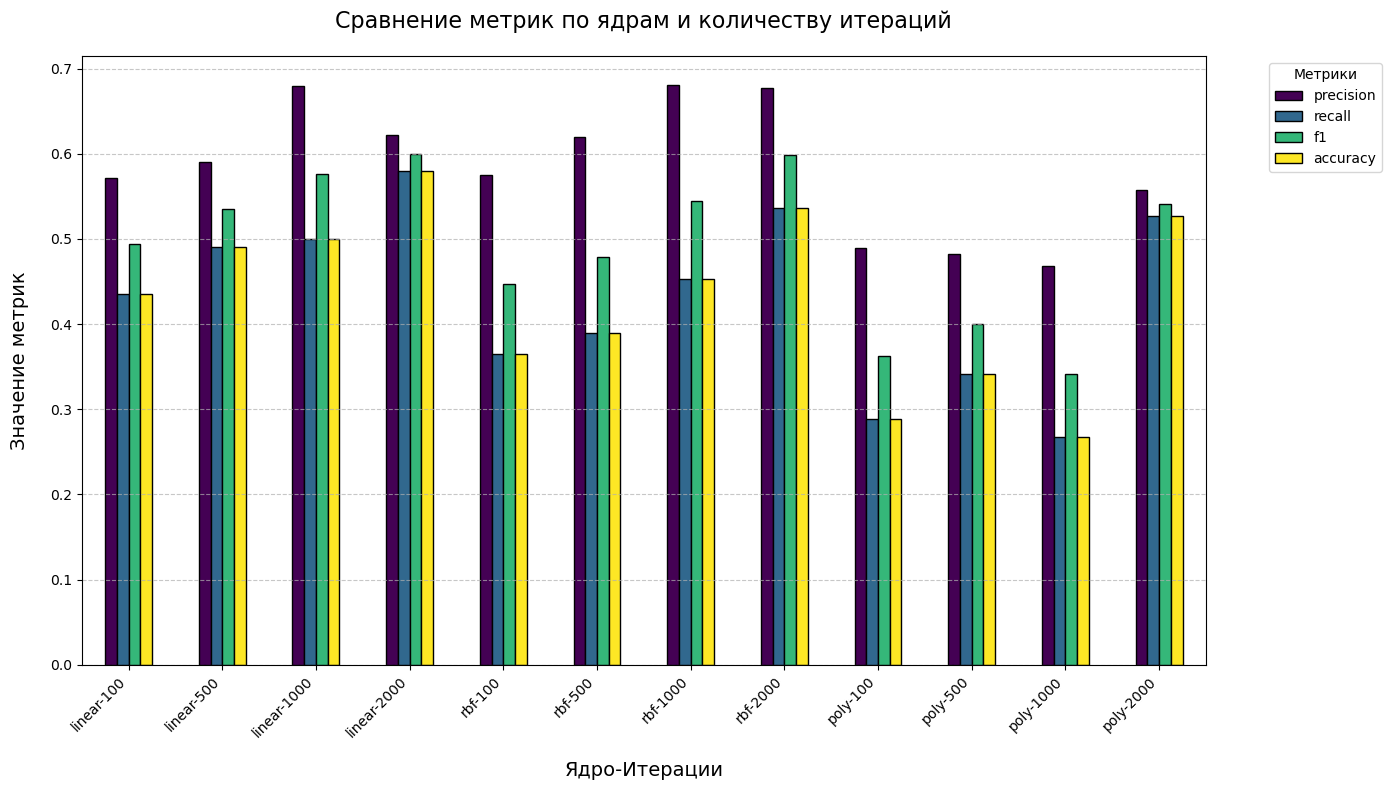

In [95]:
plt.figure(figsize=(14, 8))

df.plot(kind='bar', x='kernel_iter', y=['precision', 'recall', 'f1', 'accuracy'], 
        colormap='viridis', edgecolor='black', figsize=(14, 8))

plt.title('Сравнение метрик по ядрам и количеству итераций', pad=20, fontsize=16)
plt.xlabel('Ядро-Итерации', labelpad=15, fontsize=14)
plt.ylabel('Значение метрик', labelpad=15, fontsize=14)
plt.xticks(rotation=45, ha='right')  # Наклон подписей для удобства
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Сетка
plt.legend(title='Метрики', bbox_to_anchor=(1.05, 1), loc='upper left')  # Легенда справа

plt.tight_layout()
plt.show()

In [63]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="stratified")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

In [69]:
dummy_precision

0.25405111423971516

In [71]:
dummy_recall

0.25407894736842107

In [73]:
dummy_f1

0.25406503004178

In [75]:
dummy_accuracy

0.25407894736842107

In [97]:
from sklearn.decomposition import PCA

# Лучшая модель (линейное ядро, 2000 итераций)
best_kernel = 'linear'
best_max_iter = 2000

# Размерности для экспериментов
dimensions = [10, 20, 50, 100]  # Примерные значения

# Результаты
dimension_results = []

for dim in dimensions:
    # Применяем PCA для сокращения размерности
    pca = PCA(n_components=dim)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)
    
    # Обучаем модель
    model = SVC(kernel=best_kernel, max_iter=best_max_iter, random_state=42)
    model.fit(X_train_reduced, y_train)
    
    # Предсказание и расчет метрик
    y_pred = model.predict(X_test_reduced)
    precision, recall, f1, accuracy = calculate_metrics(y_test, y_pred)
    
    # Сохраняем результаты
    dimension_results.append({
        'dimension': dim,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    })

# Выводим результаты
for result in dimension_results:
    print(f"Dimension: {result['dimension']}, "
          f"Precision: {result['precision']:.3f}, "
          f"Recall: {result['recall']:.3f}, "
          f"F1: {result['f1']:.3f}, "
          f"Accuracy: {result['accuracy']:.3f}")

C:\Users\vepif\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\vepif\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\vepif\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\vepif\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Dimension: 10, Precision: 0.760, Recall: 0.627, F1: 0.687, Accuracy: 0.627
Dimension: 20, Precision: 0.724, Recall: 0.635, F1: 0.676, Accuracy: 0.635
Dimension: 50, Precision: 0.669, Recall: 0.595, F1: 0.630, Accuracy: 0.595
Dimension: 100, Precision: 0.622, Recall: 0.580, F1: 0.600, Accuracy: 0.580


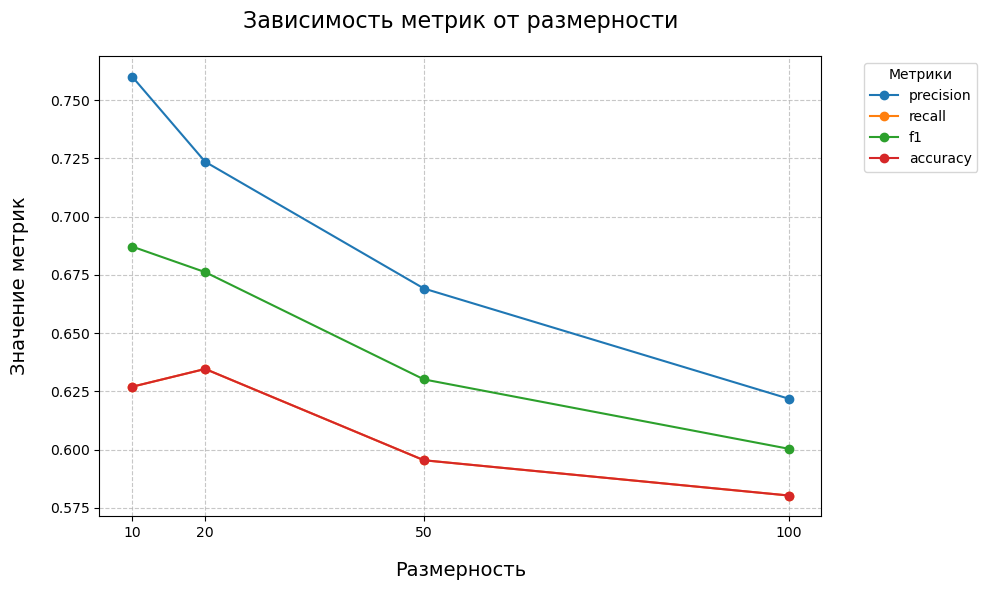

In [99]:
df_dim = pd.DataFrame(dimension_results)

# Строим график
plt.figure(figsize=(10, 6))
for metric in ['precision', 'recall', 'f1', 'accuracy']:
    plt.plot(df_dim['dimension'], df_dim[metric], marker='o', label=metric)

# Настройки графика
plt.title('Зависимость метрик от размерности', pad=20, fontsize=16)
plt.xlabel('Размерность', labelpad=15, fontsize=14)
plt.ylabel('Значение метрик', labelpad=15, fontsize=14)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(title='Метрики', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(df_dim['dimension'])  # Указываем все размерности на оси X

# Показываем график
plt.tight_layout()
plt.show()

In [101]:
def drop_random_dimensions(X, n_drop):
    """Отбрасывает случайные размерности из векторов"""
    n_features = X.shape[1]
    indices = np.random.choice(n_features, size=n_features - n_drop, replace=False)
    return X[:, indices]

# Пример использования
X_train_reduced = drop_random_dimensions(X_train, n_drop=10)
X_test_reduced = drop_random_dimensions(X_test, n_drop=10)

In [103]:
drop_random_results = []

for i in range(5):
    X_train_reduced = drop_random_dimensions(X_train, n_drop=10)
    X_test_reduced = drop_random_dimensions(X_test, n_drop=10)
    
    # Обучаем модель
    model = SVC(kernel=best_kernel, max_iter=best_max_iter, random_state=42)
    model.fit(X_train_reduced, y_train)
    
    # Предсказание и расчет метрик
    y_pred = model.predict(X_test_reduced)
    precision, recall, f1, accuracy = calculate_metrics(y_test, y_pred)
    
    # Сохраняем результаты
    drop_random_results.append({
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    })

for result in drop_random_results:
    print(f"Precision: {result['precision']:.3f}, "
          f"Recall: {result['recall']:.3f}, "
          f"F1: {result['f1']:.3f}, "
          f"Accuracy: {result['accuracy']:.3f}")

C:\Users\vepif\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\vepif\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\vepif\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\vepif\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\vepif\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2

Precision: 0.170, Recall: 0.212, F1: 0.189, Accuracy: 0.212
Precision: 0.335, Recall: 0.259, F1: 0.292, Accuracy: 0.259
Precision: 0.211, Recall: 0.286, F1: 0.242, Accuracy: 0.286
Precision: 0.162, Recall: 0.250, F1: 0.197, Accuracy: 0.250
Precision: 0.147, Recall: 0.294, F1: 0.196, Accuracy: 0.294


In [105]:
def add_dimensions(X):
    """Добавляет новые размерности с использованием математических функций"""
    new_features = np.stack([
        np.log(np.abs(X[:, 0]) + 1e-5),  # Логарифм
        np.sin(X[:, 1]),                 # Синус
        np.cos(X[:, 2]),                 # Косинус
        np.sqrt(np.abs(X[:, 3])),        # Квадратный корень
    ], axis=1)
    return np.hstack([X, new_features])

# Пример использования
X_train_extended = add_dimensions(X_train)
X_test_extended = add_dimensions(X_test)

 # Обучаем модель
model = SVC(kernel=best_kernel, max_iter=best_max_iter, random_state=42)
model.fit(X_train_extended, y_train)

# Предсказание и расчет метрик
y_pred = model.predict(X_test_extended)
precision, recall, f1, accuracy = calculate_metrics(y_test, y_pred)

C:\Users\vepif\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [107]:
precision

0.6426060447391136

In [109]:
recall

0.49473684210526314

In [111]:
f1

0.5590589943795617

In [113]:
accuracy

0.49473684210526314